In [1]:
#import libraries
import logging
logging.basicConfig(level=logging.ERROR)

import predict_hierarchy_training as pr
import hierarchy_library as hili
from predict_hierarchy_training import ExperimentStructure

import seaborn as sns
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join

import pickle
import numpy as np
import torch
import time

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.16.0-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 2.0.5-build-libtorrent-rasterbar-qrM5vM-libtorrent-rasterbar-2.0.5-bindings-python is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
####################################################
#SET WORKING DIRECTORY TO ANALYZE EXPERIMENTS IN
WORK_DIR = "projections_01/"
####################################################

raw_data = None

#find all saved experiments
e_files = [f for f in listdir(WORK_DIR) if isfile(join(WORK_DIR, f)) and f.find("experiment_") == 0 and f.find(".pickle") > 0]
print(f"Found {len(e_files)} experiment(s) in {WORK_DIR}.")

Found 3 experiment(s) in projections_01/.


In [3]:
#LOAD EXPERIMENTS

def load_experiment(idx):
    with open(f"{WORK_DIR}/{e_files[idx]}","rb") as f:
        e = pickle.load(f)
    #get and compare final validation accuracies
    #val_acc = torch.Tensor(e.acc_stats["val"], device="cpu")
    #val_acc = np.array(val_acc)[2:]
    #val_acc = np.average(val_acc.reshape(-1, e.hp["num_validation_batches"]), axis=1)
    #e.acc_stats["val"] = val_acc
    #e.data = hili.HierarchyDataModule(batch_size=e.hp["BATCH_SIZE"],features_used=e.hp["FEATURES_USED"],y_name="labels_true")
    return e
   

experiments = []
for idx in range(len(e_files)):
    print(f"Loading experiment {idx+1} ({e_files[idx]}) ... ",end="")
    experiments.append(load_experiment(idx))
    print("DONE.")
    
#find best experiment
final_acc = []
for e in experiments:
    final_acc.append(e.acc_stats["val"][-1])




print(final_acc)
best_experiment_idx = np.argmax(final_acc)
best_experiment_eID = experiments[best_experiment_idx].eID

print(f"\nBest found experiment eID = {best_experiment_eID}, idx = {best_experiment_idx}: final validation accuracy = {final_acc[best_experiment_idx]}.")

print(f"\n{experiments[best_experiment_idx].hp}")

Loading experiment 1 (experiment_QEHOTUMX.pickle) ... DONE.
Loading experiment 2 (experiment_RLMTTCDQ.pickle) ... DONE.
Loading experiment 3 (experiment_FVVQZWEM.pickle) ... DONE.
[35.83541, 35.831253, 35.821533]

Best found experiment eID = QEHOTUMX, idx = 0: final validation accuracy = 35.835411071777344.

{'BATCH_SIZE': 4096, 'EARLY_PATIENCE': 10, 'EPOCHS': 4096, 'FEATURES_USED': [4], 'LEARNING_RATE': 0.0001, 'NODES_HIDDEN1': 512, 'NODES_HIDDEN2': 512, 'WEIGHT_DECAY': 0.0, 'num_val_batches': 2481, 'num_train_batches': 9921, 'num_validation_batches': 2481}


0	35.832
1	35.829
2	35.828
3	35.829
4	35.829
5	35.830
6	35.829
7	35.829
8	35.828
9	35.831
10	35.830
11	35.831
12	35.831
13	35.830
14	35.831
15	35.831
16	35.831
17	35.830
18	35.831
19	35.830
20	35.831
21	35.831
22	35.831
23	35.831
24	35.833
25	35.832
26	35.833
27	35.833
28	35.833
29	35.834
30	35.834
31	35.833
32	35.833
33	35.833
34	35.833
35	35.834
36	35.834
37	35.834
38	35.834
39	35.834
40	35.833
41	35.834
42	35.833
43	35.834
44	35.834
45	35.835
46	35.834
47	35.836
48	35.835
49	35.834
50	35.835
51	35.835
52	35.835
53	35.834
54	35.835
55	35.834
56	35.835
57	35.835
58	35.836
59	35.835
60	35.836
61	35.836
62	35.836
63	35.836
64	35.836
65	35.836
66	35.836
67	35.835


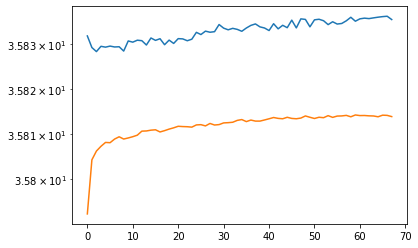

In [4]:
#plot validation experimentsmentscy
s = sns.lineplot(experiments[best_experiment_idx].acc_stats["val"])
s = sns.lineplot(experiments[best_experiment_idx].acc_stats["train"])

plt.yscale('log')
len(experiments[best_experiment_idx].acc_stats["val"])
for idx,acc in enumerate(experiments[best_experiment_idx].acc_stats["val"]):
    print(f"{idx}\t{acc:.3f}")

In [13]:
#neural network test on selected experiment
e = experiments[best_experiment_idx]
e.model = pr.HierarchyClassification.load_from_checkpoint(f"{WORK_DIR}/model_{best_experiment_eID}.ckpt")

e.trainer = pr.myTrainer(max_epochs=e.hp["EPOCHS"],patience=e.hp["EARLY_PATIENCE"])
e.data = hili.HierarchyDataModule(data_path="/mnt/pole/karlos_bordel/machine_hierarchy_data/random_states10Mc_equipartite.pickle",batch_size=e.hp["BATCH_SIZE"],features_used=e.hp["FEATURES_USED"], y_name="labels_true", t_size=0, v_size=0)
e.trainer.test(e.model,e.data)

#print(e.model.test_cms)

test_cms = [cm.numpy(force=True) for cm in e.model.test_cms[0:-1]]

#array with all confusion matrices per batch
####################################################
test_cms = np.array(test_cms).astype(int)
####################################################

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Output()

Diagonal: 1213978
Offdiagonal: 2173414
Offdiagonal/all: 64.161868481711 %
Offdiagonal/all: 52.00204168870919 %


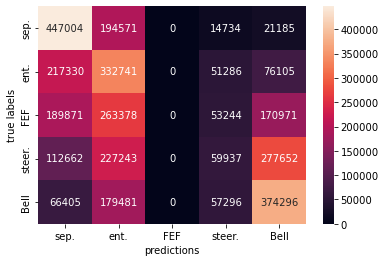

In [14]:
#DISPLAY CONFUSION MATRICES
labels = ["sep.","ent.","FEF","steer.","Bell"]
s = sns.heatmap(np.sum(test_cms,axis=0), annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
s.set(xlabel='predictions', ylabel='true labels')

#print(np.sum(test_cms,axis=0))
#print(np.mean(test_cms,axis=0))
#print(np.std(test_cms,axis=0))

cm = np.sum(test_cms, axis=0)
od = np.sum(cm)
dd = 0
for i in range(5):
    od -= cm[i,i]
    dd += cm[i,i]

#print(f"Kontrola {np.sum(cm)-od-dd}")
    
print(f"Diagonal: {dd}")
print(f"Offdiagonal: {od}")
print(f"Offdiagonal/all: {100*od/np.sum(cm)} %")
print(f"Offdiagonal/all: {100*(od-cm[0,1]-cm[1,0])/np.sum(cm)} %")

[Text(0.5, 15.0, 'predictions'), Text(33.0, 0.5, 'true labels')]

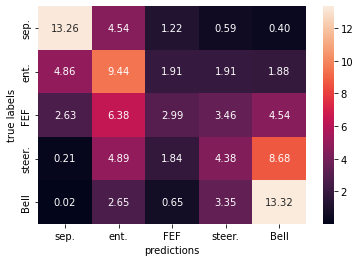

In [17]:

s2 = sns.heatmap(100*np.sum(test_cms,axis=0)/np.sum(test_cms), annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels)
s2.set(xlabel='predictions', ylabel='true labels')


In [15]:
diagonals = np.sum(np.multiply(cm,np.eye(5)),axis=0)
precisions = diagonals/np.sum(cm,axis=0)
print(f"Precisions: {precisions}")

recalls = diagonals/np.sum(cm,axis=1)
print(f"Recalls: {recalls}")

f1 = precisions*recalls/(precisions+recalls)*2
print(f"F1: {f1}")

Precisions: [0.43261019 0.277883          nan 0.25343662 0.40675108]
Recalls: [0.65979035 0.49115818 0.         0.08846868 0.55248436]
F1: [0.52257761 0.35494721        nan 0.13115446 0.46854734]


/tmp/ipykernel_1724128/3165559095.py:2: RuntimeWarning: invalid value encountered in true_divide
  precisions = diagonals/np.sum(cm,axis=0)
